In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  av.io import read
import pandas as pd
import datetime
import tensorflow as tf
#tf.enable_eager_execution()

from glob import glob
from sklearn.preprocessing import normalize
from tensorflow import keras

import string
import os



In [2]:
use_rotation_sensor = False
use_accelerometer_sensor = True
use_gyroscope_sensor = True
use_magnetic_sensor = False
sensor_inputs = 0
normalize_vector = np.array([])

if use_rotation_sensor:
    sensor_inputs += 5
    normalize_vector = np.append(normalize_vector, [1,1,1,1,1], axis=0)

if use_accelerometer_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [15,15,15], axis=0)
    
if use_gyroscope_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [3,3,3], axis=0)

if use_magnetic_sensor:
    sensor_inputs += 3
    normalize_vector = np.append(normalize_vector, [40,40,40], axis=0)


cut_shape = (100, sensor_inputs)
gestures = {0: 'Noise', 1: 'Left', 2: 'Right'}

data_folder = "data/"
patterns = {"left" : "swipe_left_20*.mkv", "right" : "swipe_right_20*.mkv", "noise" : "*noise*.mkv"} 
data_split_folder = "data_singled/"

In [3]:
def read_file(filename, lable=None):
    data, meta = read(" ".join(["a:" + str(i) for i in range(4)]), filename, 50)
    datapairs = list(zip(data, meta))
    
    df = pd.DataFrame()
    names = []
    col_name_tpls = []
    for sensor_data, stream_object in datapairs:
        meta_dict = stream_object.metadata
        # print(meta_dict)
        name = meta_dict["NAME"]
        names.append(name)
        n_cols = len(sensor_data)
        col_names = []
        for i in range(n_cols):
            col_name = name + "_" + str(i)
            col_names.append(col_name)
            df[col_name] = pd.Series(sensor_data.T[:,i])
        col_name_tpls.append(col_names)
    df.index = pd.TimedeltaIndex(freq="20ms", start=0.0, periods=len(df))
    return df, col_name_tpls

def trim_data(data_frame, start=0.0, end=None):
    if end:
        df = data_frame[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = data_frame[pd.Timedelta(10**9 * start):]
    return df

def cut_data(data_frame, cuts):
    df_cut_list = np.ndarray(shape=(len(cuts),) + cut_shape)
    for i, cut in enumerate(cuts):
        df_i = data_frame[pd.Timedelta(10**9 * cut[0]):pd.Timedelta(10**9 * cut[1])]
        start_chanel = 0
        if len(df_i) < 100:
            continue
        if not use_rotation_sensor:
            start_chanel = 5
        df_cut_list[i, : , :] = df_i.iloc[0: 100, start_chanel:8]

    return df_cut_list


def find_peaks(df, sensor, start=0.0, end=None, sel_method="right"):
    peaks = []
    if end:
        df = df[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = df[pd.Timedelta(10**9 * start):]

    for i in df.index:
        value = df[sensor][i]
        if sel_method == "right":
            cond = value > 7.5
        elif sel_method == "left":
            cond = value < -1
        if cond:
            new = True
            for peak in peaks:
                if i - pd.Timedelta(10**9) < peak + pd.Timedelta(10**9):
                    new = False
                    break
            if new:
                peaks.append(i)
    cuts = []
    for peak in peaks:
        t = peak.value / 10 ** 9
        cuts.append((t-1, t+1))
    return cuts 

def normalize_cuts(cuts):
    for i in range(len(cuts)):
        cuts[i, : , :] = cuts[i]/normalize_vector
    return cuts
  

def plot_dataframe(df, col_name_tpls):
    for col_name_tpl in col_name_tpls:
        for col_name in col_name_tpl:
            fig = df[col_name].plot()
            fig.set_title(col_name)
            plt.show()

def plot_cuts(cuts, sensor=None):
    if sensor is None:
        for i, cut in enumerate(cuts):
            plt.plot(cut, label=str(i))
            plt.legend()
            plt.show()
        return
    for cut in cuts:
        cut = cut[sensor]
        cut = cut.values.reshape(-1,1)
        print(cut.shape)
        normed_matrix = normalize(cut, axis=0, norm='l1')
        plt.plot(normed_matrix)
        
        plt.show()

In [8]:
def read_file(filename, lable=None):
    data, meta = read(" ".join(["a:" + str(i) for i in range(4)]), filename, 50)
    datapairs = list(zip(data, meta))
    
    df = pd.DataFrame()
    names = []
    col_name_tpls = []
    for sensor_data, stream_object in datapairs:
        meta_dict = stream_object.metadata
        # print(meta_dict)
        name = meta_dict["NAME"]
        names.append(name)
        n_cols = len(sensor_data)
        col_names = []
        for i in range(n_cols):
            col_name = name + "_" + str(i)
            col_names.append(col_name)
            df[col_name] = pd.Series(sensor_data.T[:,i])
        col_name_tpls.append(col_names)
    df.index = pd.TimedeltaIndex(freq="20ms", start=0.0, periods=len(df))
    return df, col_name_tpls

def trim_data(data_frame, start=0.0, end=None):
    if end:
        df = data_frame[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = data_frame[pd.Timedelta(10**9 * start):]
    return df

def cut_data(data_frame, cuts):
    df_cut_list = np.ndarray(shape=(len(cuts),) + cut_shape)
    for i, cut in enumerate(cuts):
        df_i = data_frame[pd.Timedelta(10**9 * cut[0]):pd.Timedelta(10**9 * cut[1])]
        prev_sensor_channels = 0
        if len(df_i) < 100:
            continue
        if use_rotation_sensor:
            df_cut_list[i, : , 0:5] = df_i.iloc[0: 100, 0:5]
            prev_sensor_channels += 5
        if use_accelerometer_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 5:8]
            prev_sensor_channels += 3
        if use_gyroscope_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 8:11]
            prev_sensor_channels += 3
        if use_magnetic_sensor:
            df_cut_list[i, : , prev_sensor_channels:prev_sensor_channels+3] = df_i.iloc[0: 100, 11:14]
            prev_sensor_channels += 3
    return df_cut_list


def find_peaks(df, sensor, start=0.0, end=None, sel_method="right"):
    peaks = []
    if end:
        df = df[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = df[pd.Timedelta(10**9 * start):]

    for i in df.index:
        value = df[sensor][i]
        if sel_method == "right":
            cond = value > 8
        elif sel_method == "left":
            cond = value < -1
        if cond:
            new = True
            for peak in peaks:
                if i - pd.Timedelta(10**9) < peak + pd.Timedelta(10**9):
                    new = False
                    break
            if new:
                peaks.append(i)
    cuts = []
    for peak in peaks:
        t = peak.value / 10 ** 9
        cuts.append((t-1, t+1))
    return cuts 

def normalize_cuts(cuts):
    for i in range(len(cuts)):
        cuts[i, : , :] = cuts[i]/normalize_vector
    return cuts
  

def plot_dataframe(df, col_name_tpls):
    for col_name_tpl in col_name_tpls:
        for col_name in col_name_tpl:
            fig = df[col_name].plot()
            fig.set_title(col_name)
            plt.show()

def plot_cuts(cuts, sensor=None):
    if sensor is None:
        for i, cut in enumerate(cuts):
            plt.plot(cut, label=str(i))
            plt.legend()
            plt.show()
        return
    for cut in cuts:
        cut = cut[sensor]
        cut = cut.values.reshape(-1,1)
        print(cut.shape)
        normed_matrix = normalize(cut, axis=0, norm='l1')
        plt.plot(normed_matrix)
        plt.show()

In [5]:
for gesture in patterns.keys():
    gesture_file_list = glob(data_folder + patterns[gesture])
    print(gesture_file_list)

['data/swipe_left_20_0.mkv']
['data/swipe_right_20_0.mkv', 'data/swipe_right_20_1.mkv']
['data/noise_0.mkv', 'data/noise_1.mkv']


In [10]:
def export_data(force_overwrite=False, do_result_plots=False):
    """export all the data!!
    force_overwrite: overwrite already exported data
    do_result_plots: show plots of resulting gesture cuts again.
    """
    for gesture in patterns.keys():
        gesture_file_list = glob(data_folder + patterns[gesture])
        k = 0
        for filename in gesture_file_list:
            assert filename.count("/") == 1
            rev_file = filename[::-1]

            ind = len(filename) - rev_file.index("_")
            gesture_name = filename[filename.index("/")+1:ind-1]
            gesutre_name_copy = gesture_name
            while gesture_name[-1].lower() not in string.ascii_lowercase:
                gesture_name = gesture_name[:-1]
            try:
                num_cuts = int(gesutre_name_copy[len(gesture_name) - len(gesutre_name_copy) +1:])
            except:
                print(f"WARNING, in FILE DOES NOT SET AMOUNT OF CUTS: {filename}")
                num_cuts = False
            number = filename[ind:filename.index(".")]
            if os.path.isfile(data_split_folder + gesture_name + "_" + number + "_000.csv") and not force_overwrite:
                continue
            df, col_name_tpls = read_file(filename)
            df["Cywee Accelerometer Sensor_2"].plot()
            plt.show()
            start = int(input("start?"))
            try:
                end = int(input("end?"))
            except:
                end = False
            if end:
                trimed_df = trim_data(df, start, end)
            else:
                trimed_df = trim_data(df, start)
            peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
            print(len(peaks), ":", peaks)
            cuts = normalize_cuts(cut_data(trimed_df, peaks))
            print("Found cuts:", len(cuts))
            plot_cuts(cuts)
            r = eval(input("remove cuts?? (divide by \',\') "))
            assert type(r) == list
            l_cuts = []   # list to keep cuts
            for i, cut in enumerate(cuts):
                if i not in r:
                    l_cuts.append(cut)
            #cuts = np.asarray(l)
            if num_cuts:
                if len(l_cuts) != num_cuts:
                    print(f"WARNING: expected{num_cuts} but got {len(l_cuts)}")
                else:
                    print("correct number of cuts reached")
            for n, cut in enumerate(l_cuts):
                n_str = str(n)
                while len(n_str) < 3:
                    n_str = "0" + n_str
                np.savetxt(data_split_folder + gesture_name + "_" + number + "_" + n_str + ".csv", cut, delimiter=",")
            if do_result_plots:
                plot_cuts(l_cuts)

/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


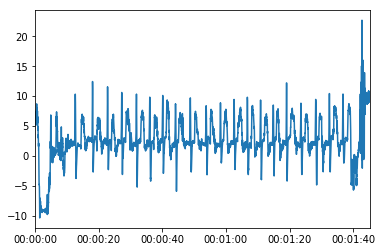

start?10
end?98
22 : [(11.56, 13.56), (16.98, 18.98), (21.72, 23.72), (26.18, 28.18), (30.8, 32.8), (35.0, 37.0), (39.06, 41.06), (43.1, 45.1), (47.74, 49.74), (52.76, 54.76), (57.24, 59.24), (61.54, 63.54), (63.58, 65.58), (65.7, 67.7), (69.86, 71.86), (73.9, 75.9), (78.02, 80.02), (82.56, 84.56), (87.2, 89.2), (91.5, 93.5), (93.52, 95.52), (95.78, 97.78)]
Found cuts: 22


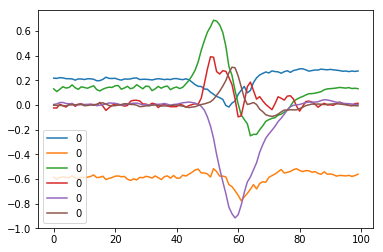

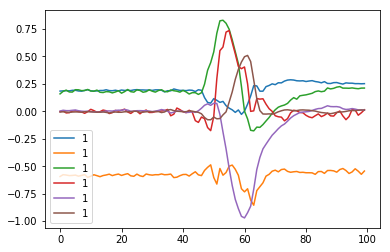

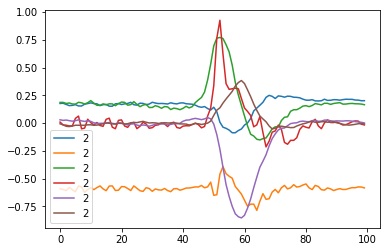

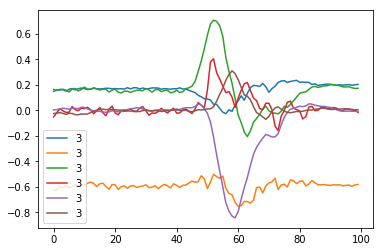

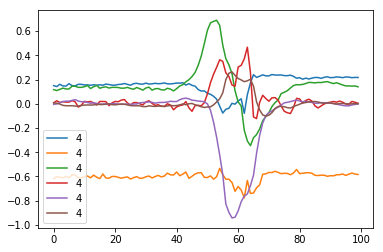

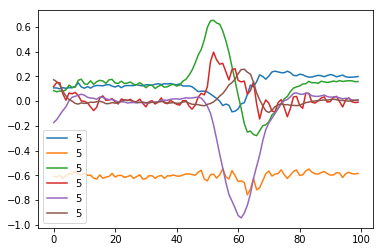

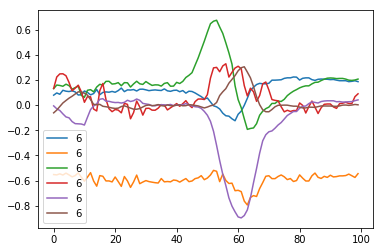

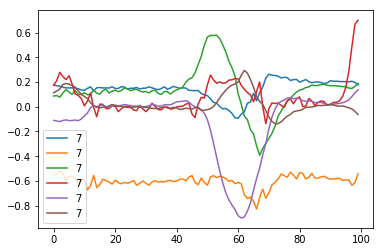

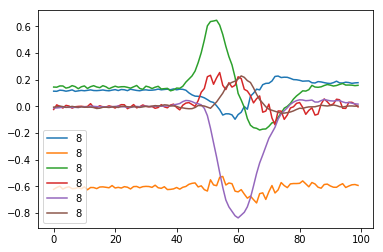

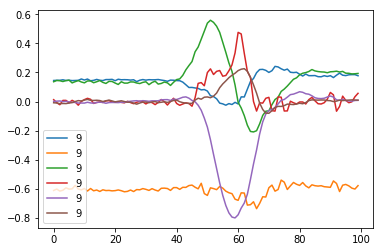

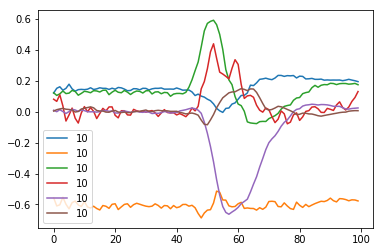

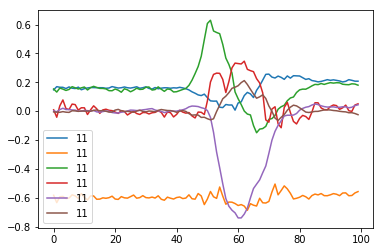

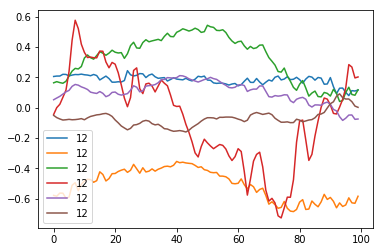

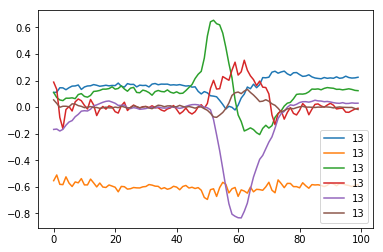

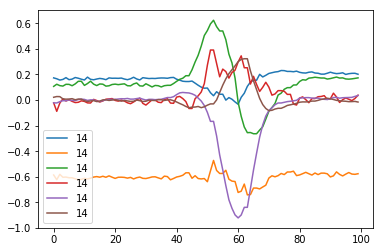

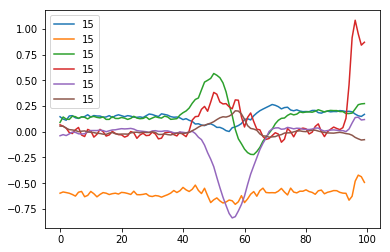

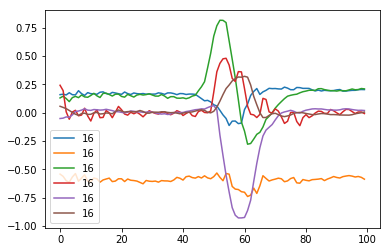

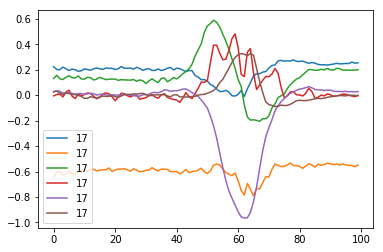

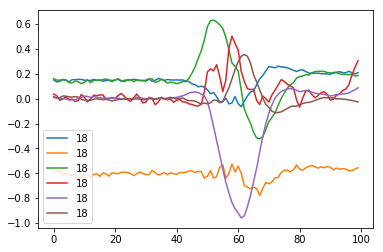

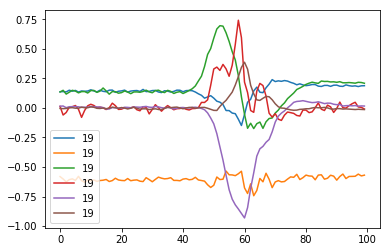

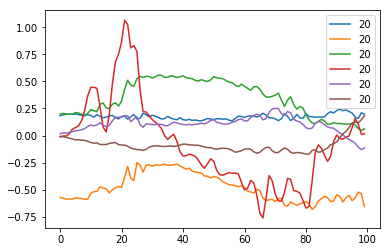

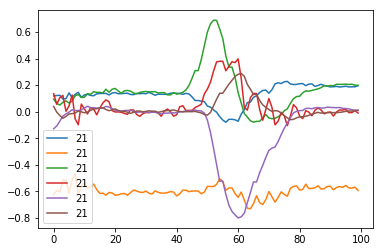

remove cuts?? (divide by ',') [12,20]


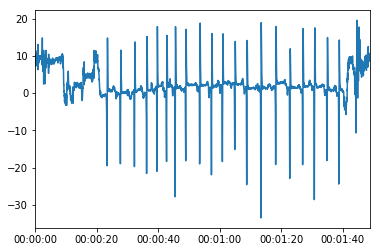

start?20
end?102
22 : [(19.0, 21.0), (22.48, 24.48), (26.86, 28.86), (31.4, 33.4), (35.36, 37.36), (38.72, 40.72), (41.84, 43.84), (44.62, 46.62), (48.06, 50.06), (52.64, 54.64), (56.44, 58.44), (60.02, 62.02), (64.06, 66.06), (67.92, 69.92), (72.52, 74.52), (77.36, 79.36), (81.92, 83.92), (86.12, 88.12), (89.92, 91.92), (94.08, 96.08), (97.9, 99.9), (100.9, 102.9)]
Found cuts: 22


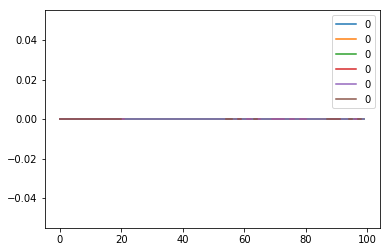

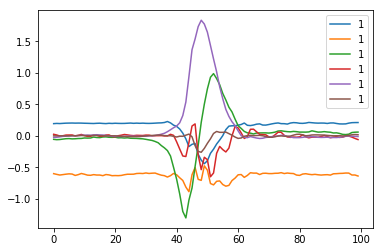

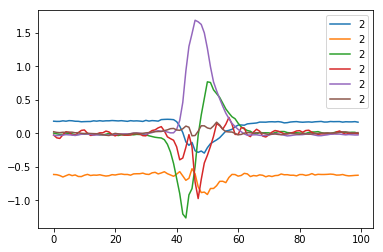

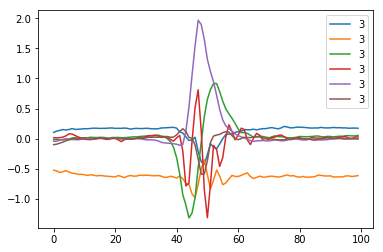

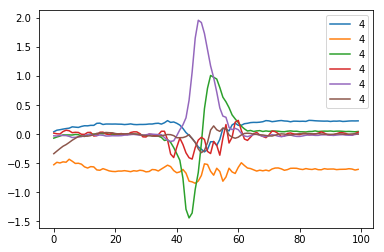

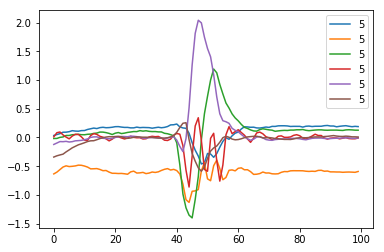

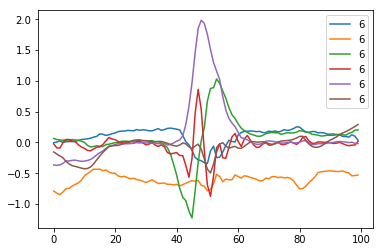

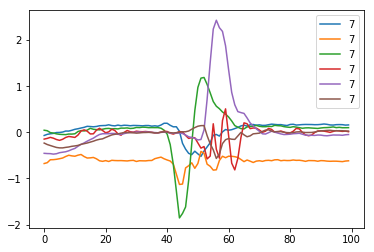

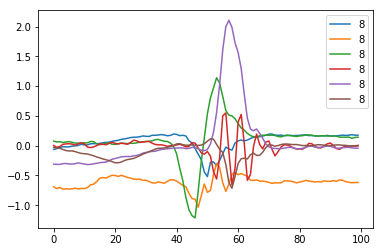

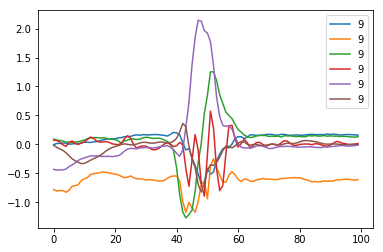

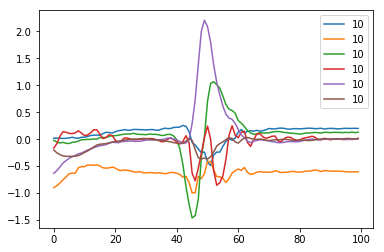

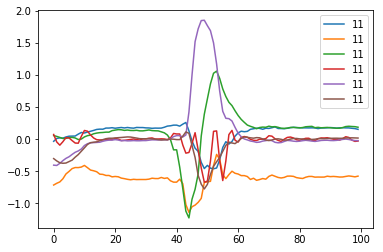

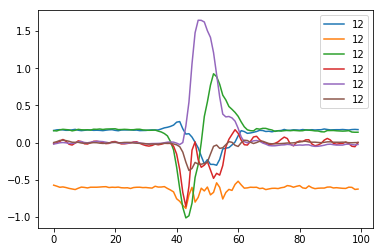

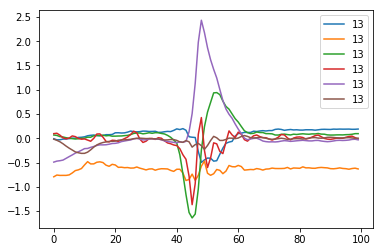

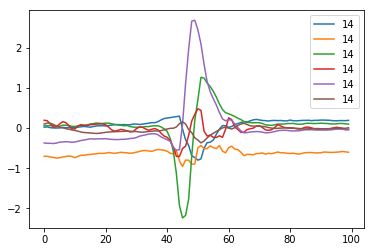

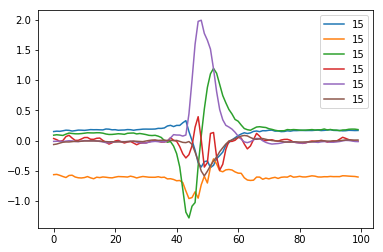

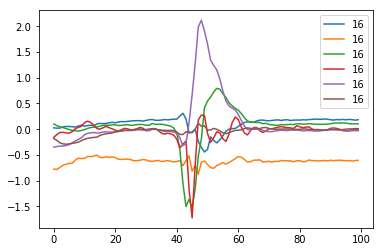

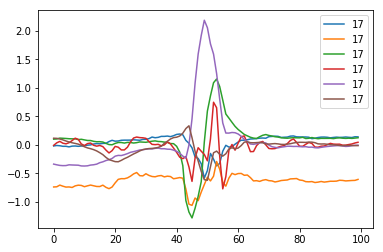

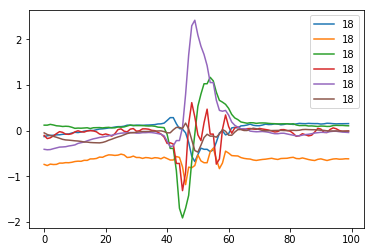

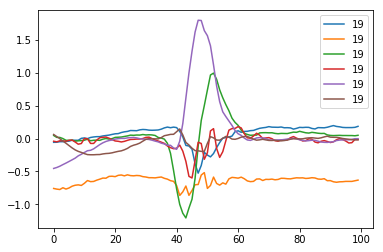

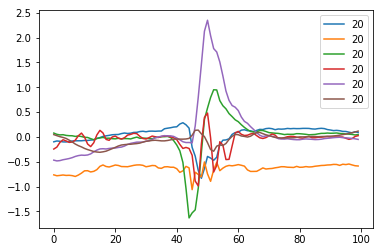

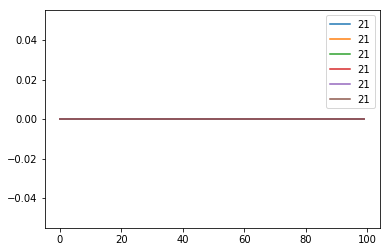

remove cuts?? (divide by ',') [0,21]


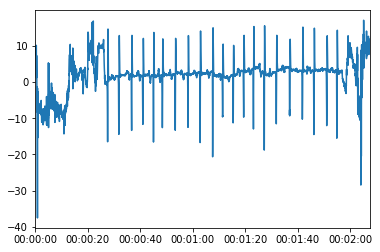

start?23
end?118
22 : [(22.84, 24.84), (24.84, 26.84), (30.98, 32.980000000000004), (35.82, 37.82), (40.12, 42.12), (44.14, 46.14), (47.56, 49.56), (52.44, 54.44), (57.3, 59.3), (61.9, 63.9), (66.68, 68.68), (70.52, 72.52), (74.54, 76.54), (78.5, 80.5), (82.2, 84.2), (86.32, 88.32), (90.94, 92.94), (96.0, 98.0), (100.88, 102.88), (105.26, 107.26), (110.14, 112.14), (113.98, 115.98)]
Found cuts: 22


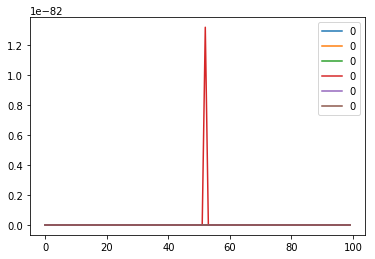

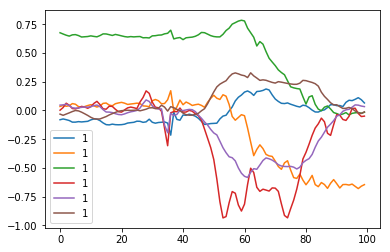

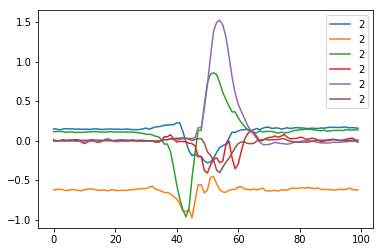

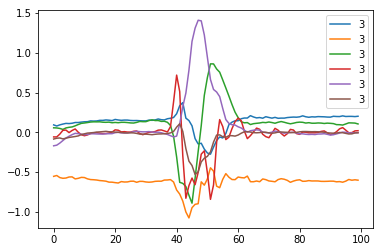

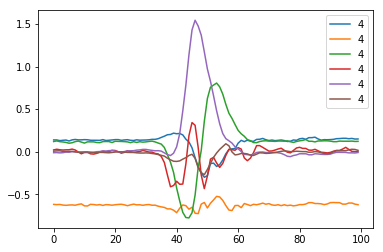

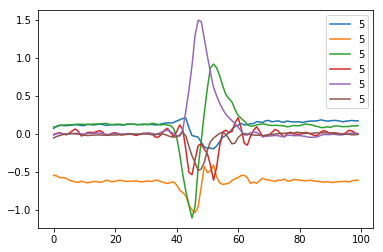

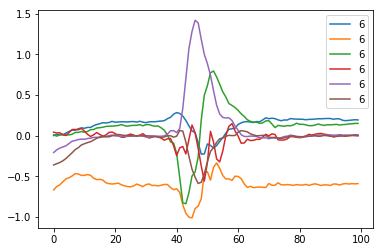

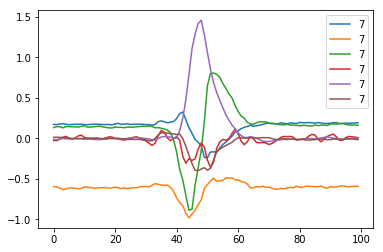

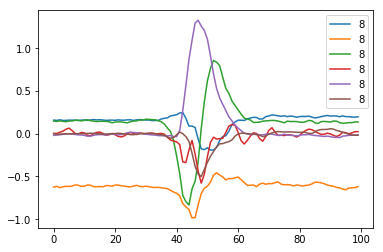

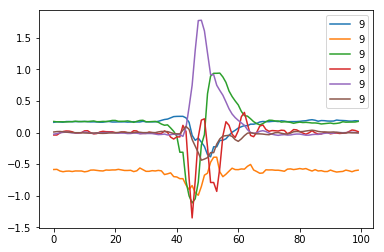

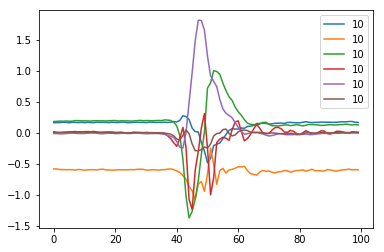

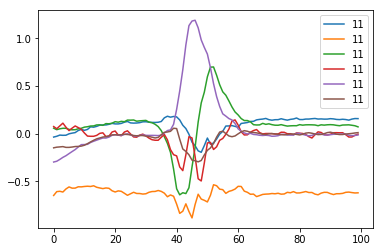

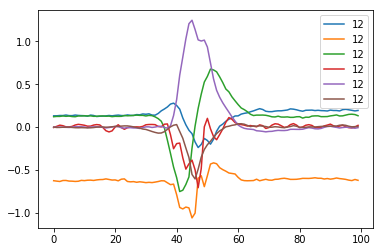

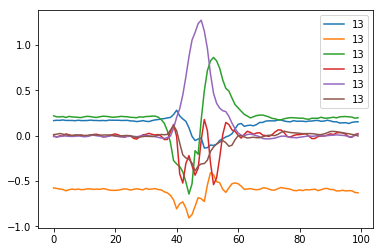

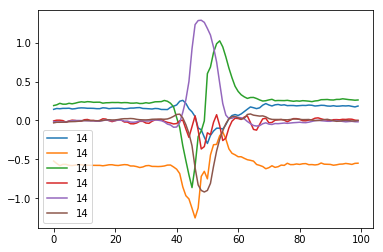

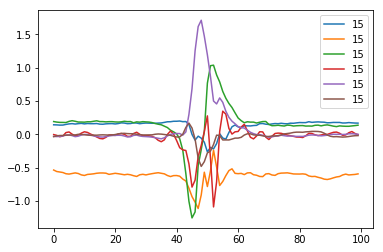

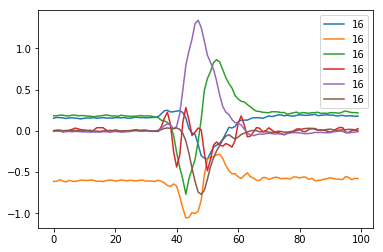

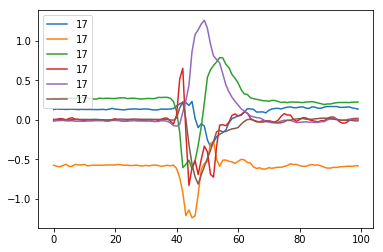

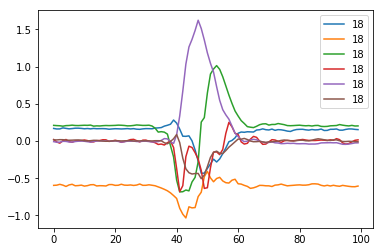

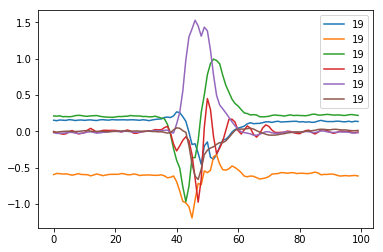

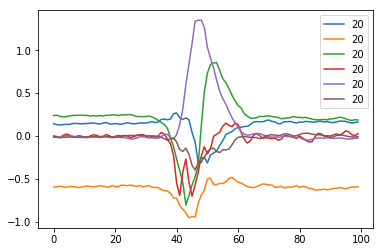

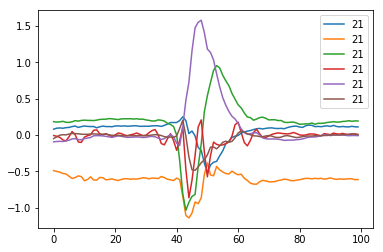

remove cuts?? (divide by ',') [0,1]
WARNING, in FILE DOES NOT SET AMOUNT OF CUTS: data/noise_0.mkv


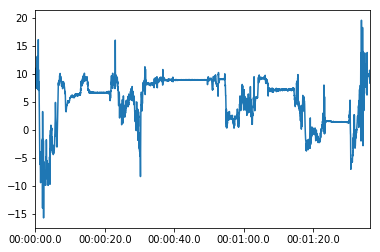

start?0
end?
24 : [(-1.0, 1.0), (5.64, 7.64), (12.14, 14.14), (14.14, 16.14), (20.84, 22.84), (30.08, 32.08), (32.08, 34.08), (34.08, 36.08), (36.08, 38.08), (38.08, 40.08), (40.08, 42.08), (42.08, 44.08), (44.08, 46.08), (46.08, 48.08), (48.08, 50.08), (50.22, 52.22), (52.22, 54.22), (58.62, 60.62), (62.04, 64.03999999999999), (64.04, 66.04), (66.04, 68.04), (74.28, 76.28), (92.76, 94.76), (94.76, 96.76)]
Found cuts: 24


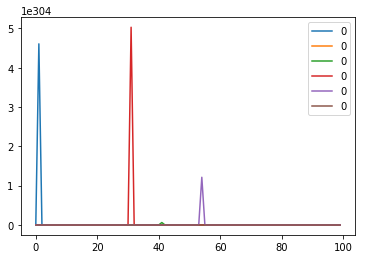

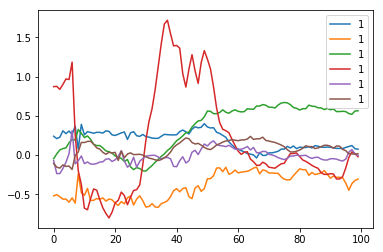

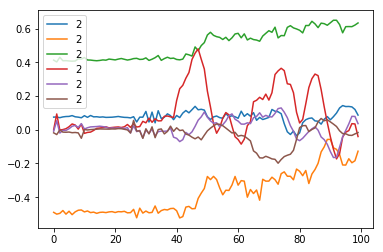

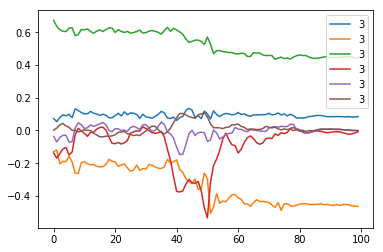

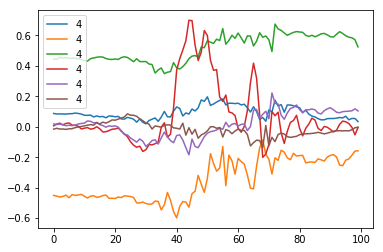

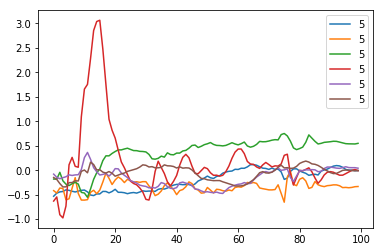

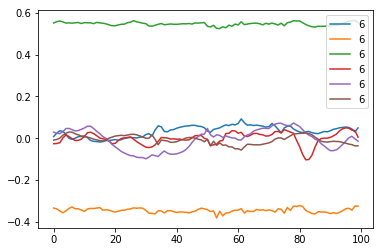

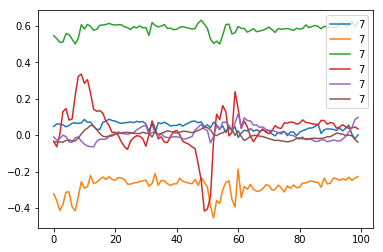

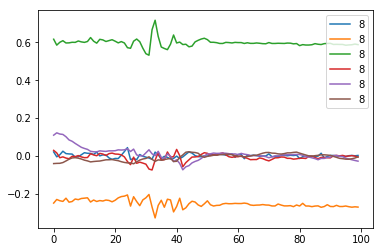

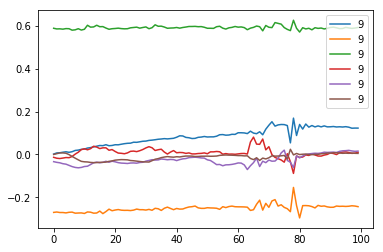

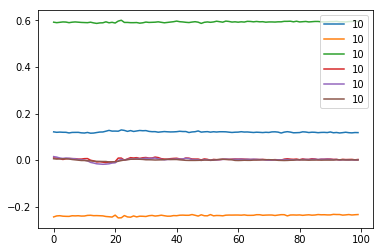

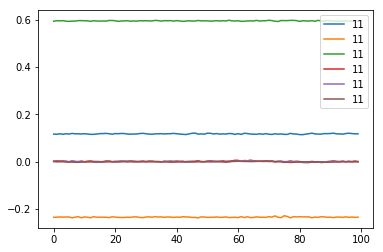

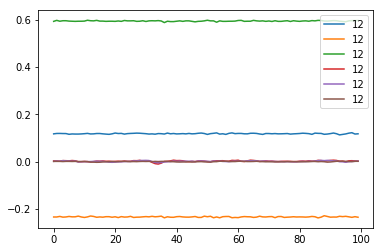

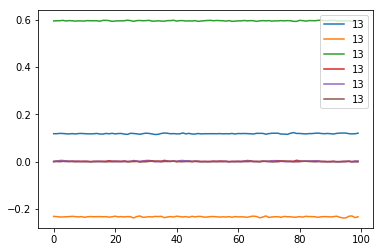

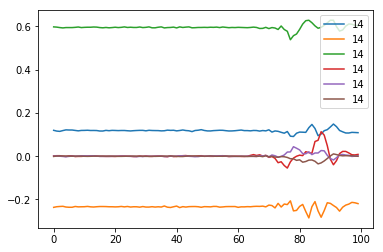

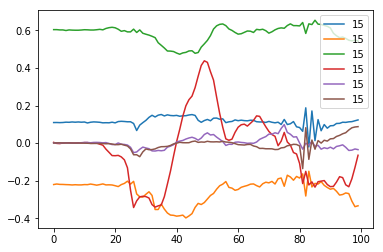

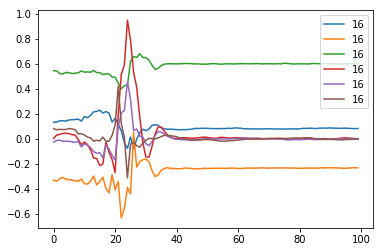

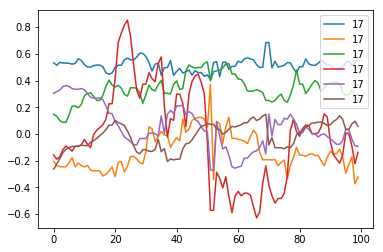

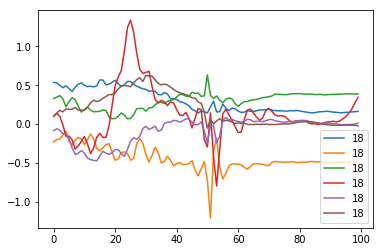

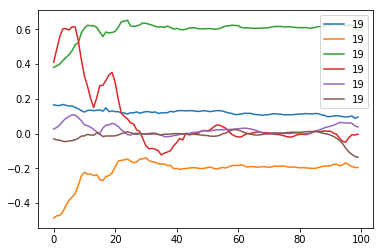

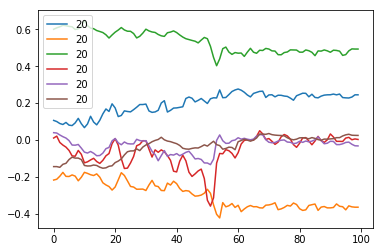

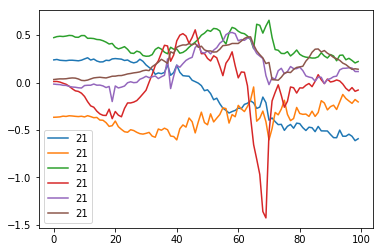

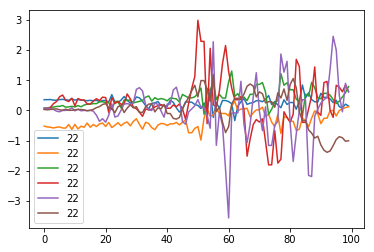

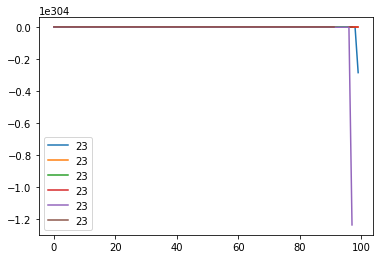

remove cuts?? (divide by ',') []
WARNING, in FILE DOES NOT SET AMOUNT OF CUTS: data/noise_1.mkv


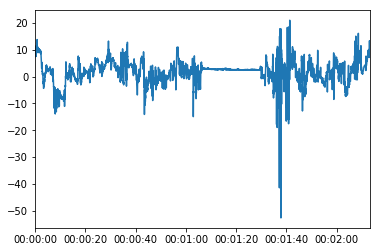

start?0
end?
19 : [(-1.0, 1.0), (1.0, 3.0), (27.78, 29.78), (33.06, 35.06), (35.1, 37.1), (42.12, 44.12), (55.32, 57.32), (90.86, 92.86), (93.54, 95.54), (95.66, 97.66), (99.34, 101.34), (101.4, 103.4), (106.08, 108.08), (108.12, 110.12), (111.4, 113.4), (117.76, 119.76), (126.24, 128.24), (128.26, 130.26), (131.34, 133.34)]
Found cuts: 19


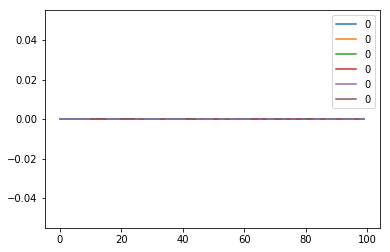

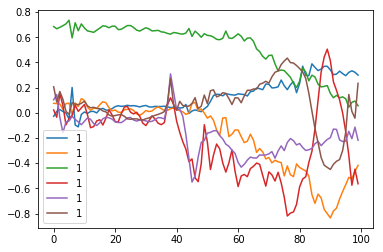

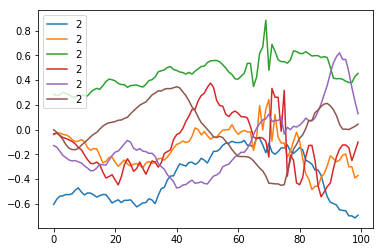

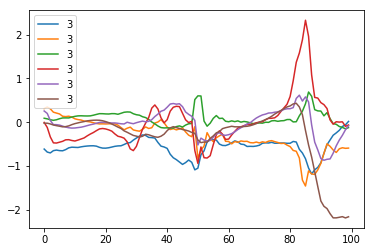

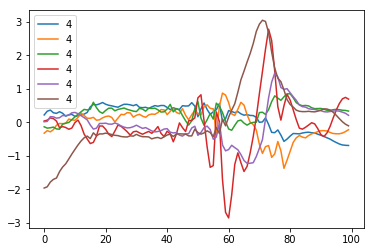

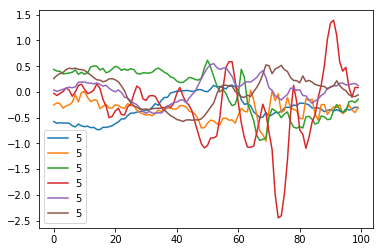

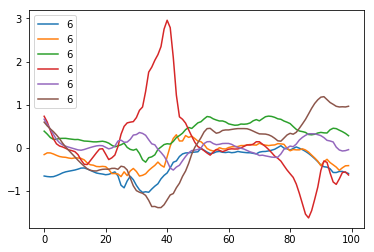

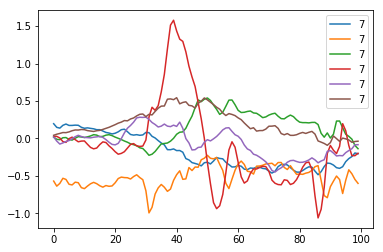

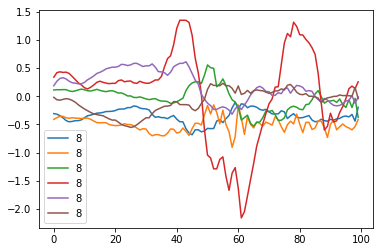

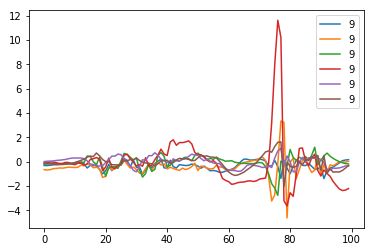

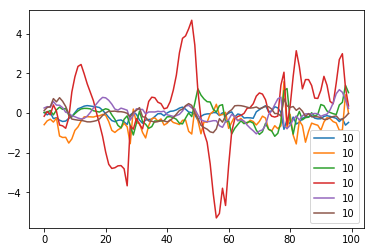

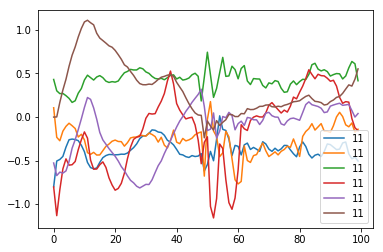

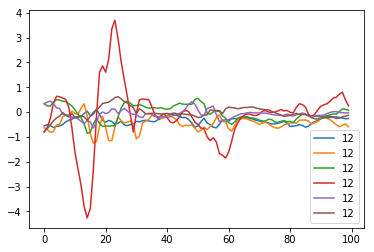

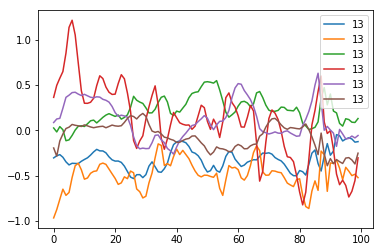

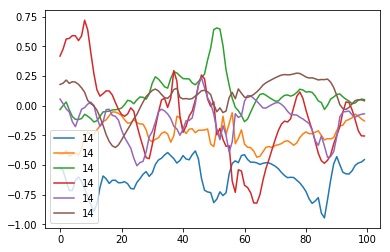

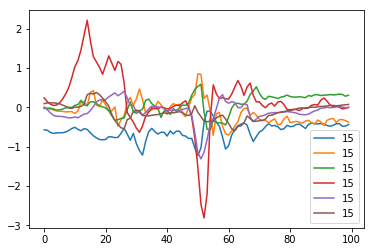

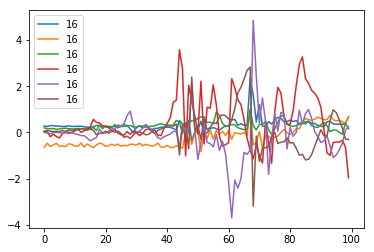

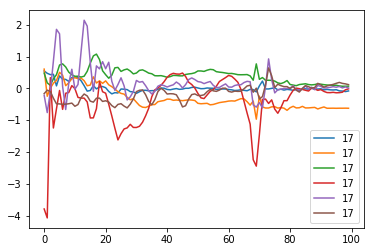

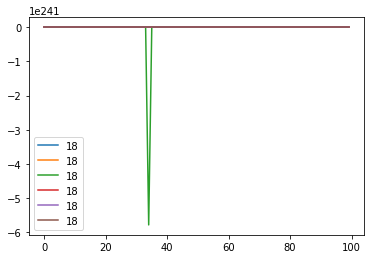

remove cuts?? (divide by ',') []


In [9]:
export_data()

/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


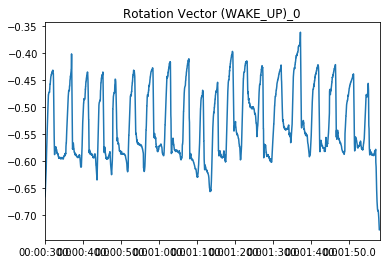

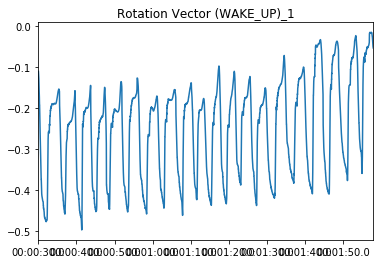

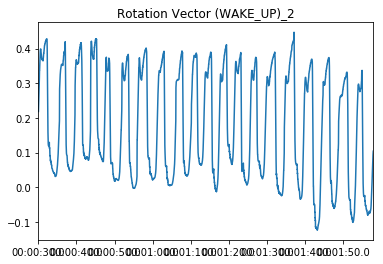

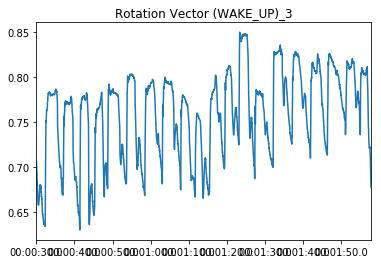

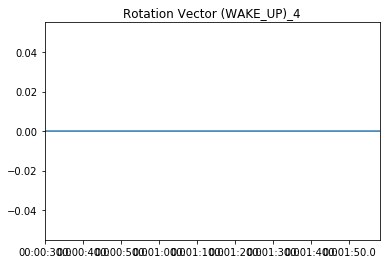

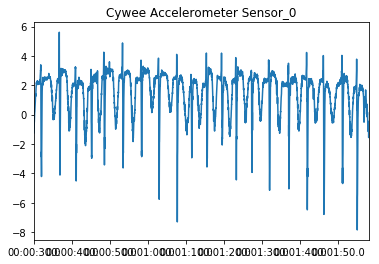

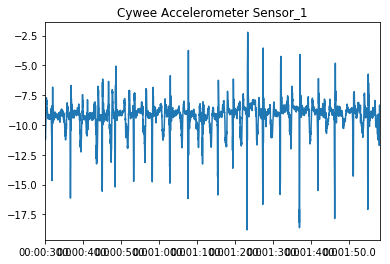

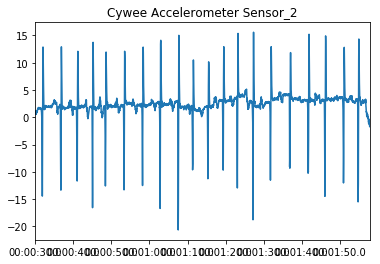

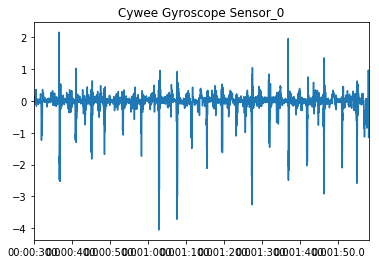

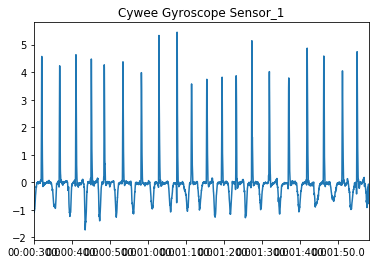

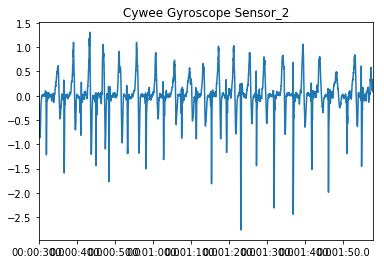

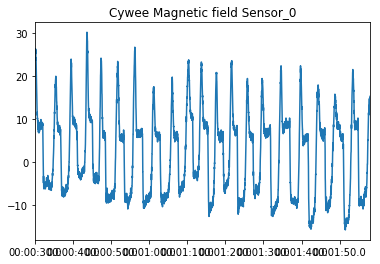

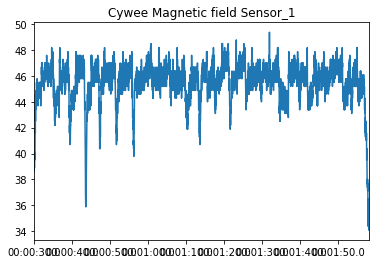

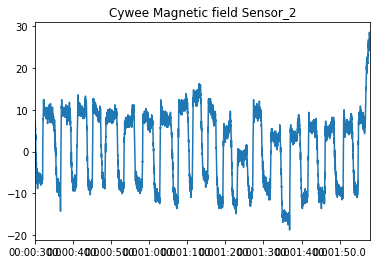

20 : [(30.98, 32.980000000000004), (35.82, 37.82), (40.12, 42.12), (44.14, 46.14), (47.56, 49.56), (52.44, 54.44), (57.3, 59.3), (61.9, 63.9), (66.68, 68.68), (70.52, 72.52), (74.54, 76.54), (78.5, 80.5), (82.2, 84.2), (86.32, 88.32), (90.94, 92.94), (96.0, 98.0), (100.88, 102.88), (105.26, 107.26), (110.14, 112.14), (113.98, 115.98)]
Found cuts: 20


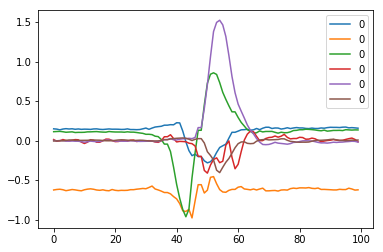

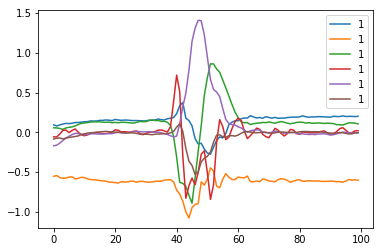

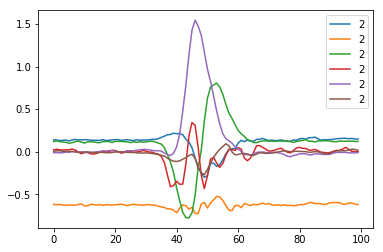

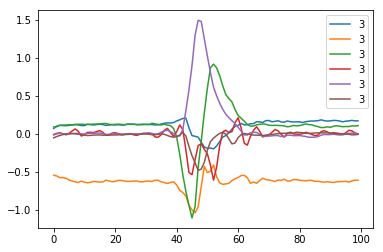

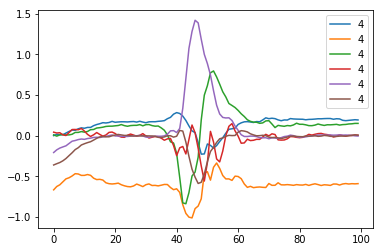

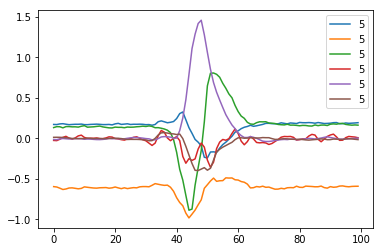

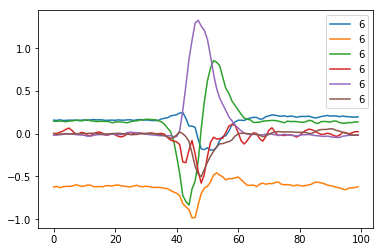

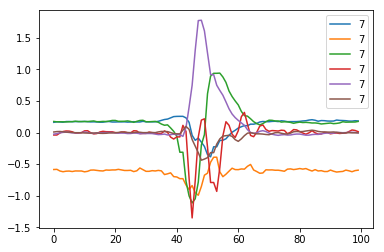

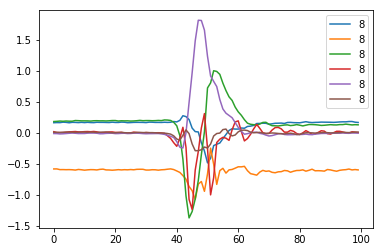

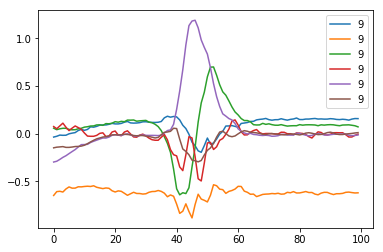

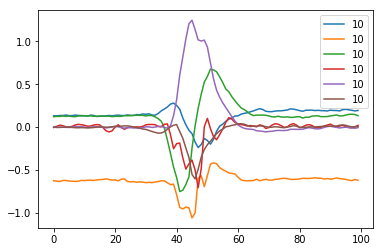

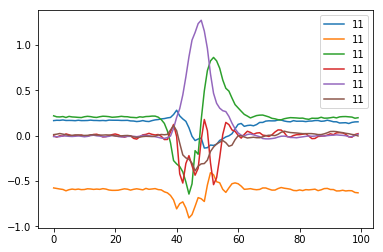

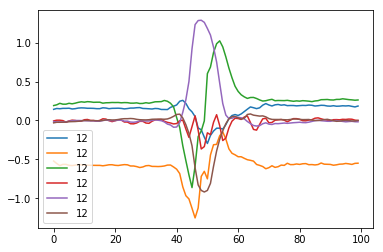

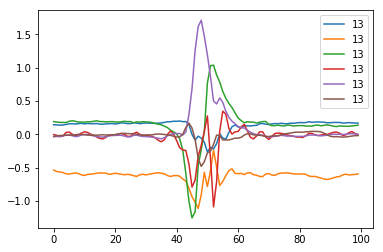

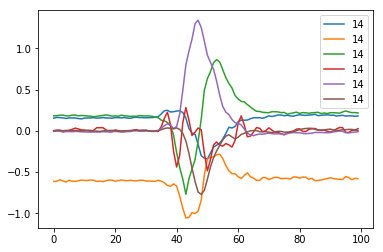

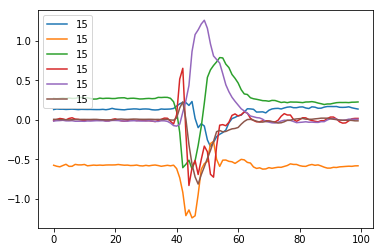

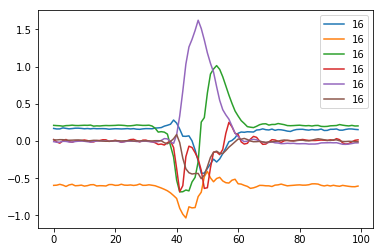

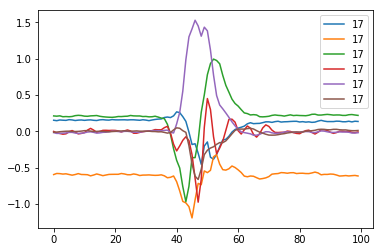

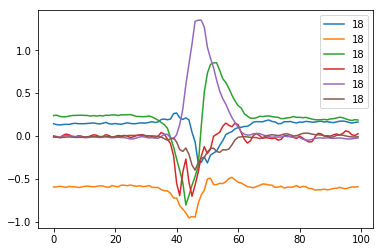

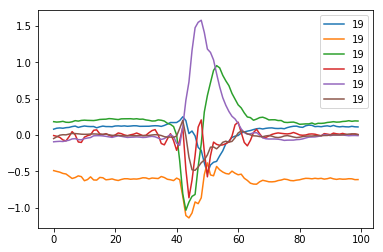

In [11]:
df, col_name_tpls = read_file("data/swipe_right_20_1.mkv")
trimed_df = trim_data(df, 30,118)
plot_dataframe(trimed_df, col_name_tpls)
peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
print(len(peaks), ":", peaks)
cuts = normalize_cuts(cut_data(trimed_df, peaks))
print("Found cuts:", len(cuts))
plot_cuts(cuts)

In [ ]:
def  learn_clisifyer(data, lables):
    print(data.shape)
    model = keras.Sequential([
        #keras.layers.Flatten(),
        keras.layers.Flatten(input_shape=cut_shape),
        keras.layers.Dense(100 * len(normalize_vector), activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(data, lables, epochs=50)
    test_loss, test_acc = model.evaluate(data, lables)

    print('Test accuracy:', test_acc)
    
    return model

    



In [ ]:
def prepare_learn_set(data_frame, previous_learned_data=None):
    peaks = find_peaks(data_frame, "Cywee Accelerometer Sensor_2")
    cuts = cut_data(data_frame, peaks)
    #cuts_full = [cut for cut in cuts if len(cut) == 100]
    learn_data = normalize_cuts(cuts) # Normalize
    print("DataShape:", learn_data.shape)
    
    if previous_learned_data is not None:
        learn_data = np.append(learn_data, previous_learned_data, axis=0)
    return learn_data
    
    

# Use Tensorflow to classify gestures

## Learn model


In [ ]:
df, col_name_tpls = read_file("swipe_right_10_new.mkv")
trimed_df = trim_data(df, 52, 90)
learn_data_r = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("swipe_left_10.mkv")
trimed_df = trim_data(df, 10, 57)
learn_data_l = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("data/swipe_left_20_0.mkv")
trimed_df = trim_data(df, 15, 90)
learn_data_l = prepare_learn_set(trimed_df, learn_data_l)

df, col_name_tpls = read_file("random_noise.mkv")
trimed_df = trim_data(df, 0)
cuts = cut_data(trimed_df, [(i * 2, i*2+2) for i in range(50)])
learn_data_noise = normalize_cuts(cuts)
print("Noiseshape:", learn_data_noise.shape)
print("Learn L shape:", learn_data_l.shape)

learn_data = np.append(learn_data_noise, learn_data_l, axis=0)
learn_data = np.append(learn_data, learn_data_r, axis=0)

lables = [0]*len(learn_data_noise) + [1]*len(learn_data_l) + [2]*len(learn_data_r)

print("Learn data has shape: {}".format(learn_data.shape))
model = learn_clisifyer(learn_data, lables)


# Test learned model
Test data has gestures:
Left, Left, Left, Left, Right, Right, Right, Left, Left

In [ ]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
test_data = prepare_learn_set(trimed_df) 
test_lables = [1, 1, 1, 1, 2, 2, 2, 1, 1]

predictions = model.predict(test_data)
print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[np.argmax(p)], 
                                         gestures[test_lables[i]], np.argmax(p) == test_lables[i]))

print('\nTest if noise will be predicted as noise')
df, col_name_tpls = read_file("data/noise_test.mkv")
trimed_df = trim_data(df, 16, 88)
learn_data_noise = prepare_learn_set(trimed_df)
noise_predictions = model.predict(learn_data_noise)
for p in noise_predictions:
    print(gestures[np.argmax(p)])

In [ ]:
for p in predictions:
    print(max(p))

In [ ]:
for p in noise_predictions:
    if np.argmax(p) != 0:
        print("classified as left or right with confidence {:.2f}%".format(max(p)*100))
    else:
        print("classified as noise,", max(p))

# Train SVM:

## Define features

In [ ]:
import sklearn.svm

def get_features(tf_learn_data, mode="features"):
    out_data = []
    for learn_data in tf_learn_data:
        feature_vec = []
        for split in range(15,101, 15):
            cur_split = learn_data[split-15:split+10]
            for i in range(3):
                sensor_data  = cur_split[:,i]
                feature_vec.append(sensor_data.mean())
                feature_vec.append(sensor_data.max())
                feature_vec.append(sensor_data.min())
                feature_vec.append(np.median(sensor_data))
        if mode == "features":
            out_data.append(feature_vec)
        elif mode == "raw":
            out_data.append(learn_data.flatten())
    return np.array(out_data)

## Train with features


In [ ]:
X_train = get_features(learn_data)
y = lables

X_test = test_data
y_test = test_lables


clf = sklearn.svm.SVC(gamma=1.0, decision_function_shape='ovo', probability=True)
clf.fit(X_train, y) 
predictions = clf.predict(get_features(test_data))

print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[p], 
                                         gestures[y_test[i]], p == y_test[i]))

    
print(clf.predict(get_features(learn_data_noise)))

In [ ]:
X_train.shape

## Test on test data

 - tensorflow model
 - svm classifies

In [ ]:
def predict_from_file(filename, mode="tensorflow", print_res=False):
    """
    pipeline including reading the file, running a classifier
    and outputting the results
    """
    df, col_name_tpls = read_file(filename)
    length = len(df) / 50
    trimed_df = trim_data(df, 5, length-1)
    test_data = prepare_learn_set(trimed_df)
    if mode == "tensorflow":
        res = model.predict(test_data)
    elif mode == "svm":
        res = clf.predict_proba(get_features(test_data))
    preds_and_confs = [(np.argmax(p), p[np.argmax(p)]) for p in res]
    if print_res:
        print([gestures[p[0]] for p in preds_and_confs])
    return np.array(preds_and_confs)

    

In [ ]:
predict_from_file("swipe_test_both.mkv", "svm")


In [ ]:
predict_from_file("swipe_test_both.mkv", "tensorflow")

In [ ]:
predict_from_file("data/swipe_right_20_1.mkv", "tensorflow")

In [ ]:
def live_demo(filename="data/live_demo.mkv"):
    import warnings
    warnings.filterwarnings("ignore")
    res_tf = predict_from_file(filename, "tensorflow")
    res_svm = predict_from_file(filename, "svm")
    
    res_tf = [gestures[p[0]] for p in res_tf if p[1] > 0.94]
    res_svm = [gestures[p[0]] for p in res_svm if p[1] > 0.5]
    print("\n\nPredictions:\n")
    """
    for i, gesture in enumerate(res_tf):
        print(i+1, ":", gesture, sep=" ")
    print("=" * 20)
    for i, gesture in enumerate(res_svm):
        print(i+1, ":", gesture, sep=" ")
    """
    df = pd.DataFrame(list(zip(res_tf, res_svm)), columns=["tensorflow", "SVC"])
    return df
    

In [ ]:
res_df = live_demo("data/test_demo.mkv")
res_df